# MLP Regressor

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_squared_error, r2_score

### Create Custom Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


### Create Model Architecture

In [3]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.hidden1 = nn.Linear(17, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.3)  # Increased dropout
        
        self.hidden2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.hidden3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.hidden4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.relu4 = nn.ELU()
        
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.hidden1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.hidden2(x))))
        x = self.dropout3(self.relu3(self.batch_norm3(self.hidden3(x))))
        x = self.relu4(self.batch_norm4(self.hidden4(x)))
        x = self.output(x)
        return x

### Data Loading and Cleaning

In [4]:
# Load the data
df = pd.read_csv('../Data/dataset83.csv')
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

# Convert categorical columns to numeric labels
label_encoder = LabelEncoder()
df['Species'] = label_encoder.fit_transform(df['Species'])
df['Population'] = label_encoder.fit_transform(df['Population'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Converting a column to float
df['Thorax_length'] = pd.to_numeric(df['Thorax_length'], errors='coerce').astype('float64')

# Converting a column to int (after ensuring it's first converted to float to handle non-integer formats)
df['wing_loading'] = pd.to_numeric(df['wing_loading'], errors='coerce').astype('float64')

# Fill in missing values 
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)

### Seperate Label/Features Normalise/Scale

In [5]:
# Define your data
X = df.drop('wing_loading', axis=1).values
y = df['wing_loading'].values

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

### Split Data into Train and Test

In [6]:
# Split data into train_val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=4200)

### Define Training

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Adjust the learning rate based on the val loss
        scheduler.step(val_loss)

    return train_losses, val_losses

### Perform 10 Fold CV Training

Training fold 1/10
Epoch 1/100 - Train Loss: 3.0576, Val Loss: 2.5717
Epoch 2/100 - Train Loss: 2.1227, Val Loss: 1.8068
Epoch 3/100 - Train Loss: 1.3229, Val Loss: 0.9333
Epoch 4/100 - Train Loss: 0.7272, Val Loss: 0.4750
Epoch 5/100 - Train Loss: 0.3328, Val Loss: 0.1882
Epoch 6/100 - Train Loss: 0.1454, Val Loss: 0.0567
Epoch 7/100 - Train Loss: 0.0758, Val Loss: 0.0215
Epoch 8/100 - Train Loss: 0.0578, Val Loss: 0.0200
Epoch 9/100 - Train Loss: 0.0514, Val Loss: 0.0091
Epoch 10/100 - Train Loss: 0.0472, Val Loss: 0.0101
Epoch 11/100 - Train Loss: 0.0419, Val Loss: 0.0099
Epoch 12/100 - Train Loss: 0.0398, Val Loss: 0.0080
Epoch 13/100 - Train Loss: 0.0450, Val Loss: 0.0073
Epoch 14/100 - Train Loss: 0.0354, Val Loss: 0.0052
Epoch 15/100 - Train Loss: 0.0367, Val Loss: 0.0061
Epoch 16/100 - Train Loss: 0.0310, Val Loss: 0.0053
Epoch 17/100 - Train Loss: 0.0305, Val Loss: 0.0065
Epoch 18/100 - Train Loss: 0.0278, Val Loss: 0.0042
Epoch 19/100 - Train Loss: 0.0252, Val Loss: 0.0034
Ep

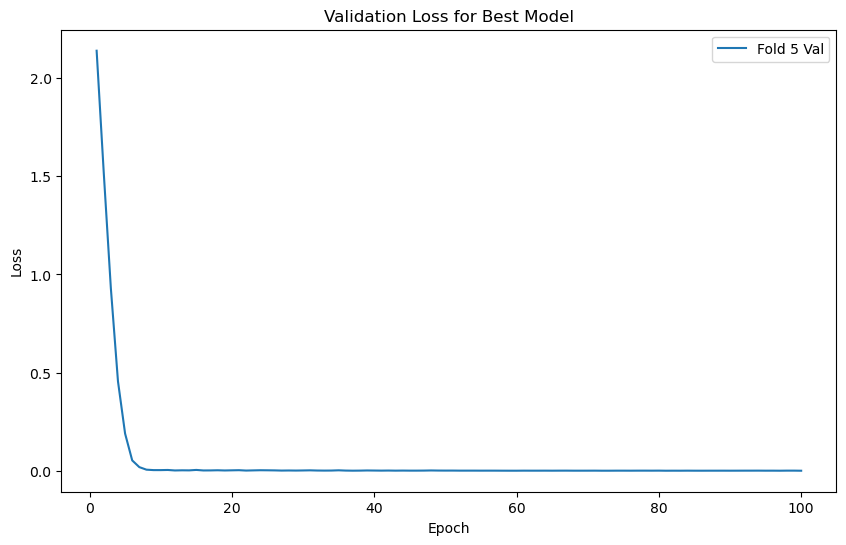

In [8]:
# Initialize parameters
num_epochs = 100
batch_size = 32
criterion = torch.nn.MSELoss()
kf = KFold(n_splits=10, shuffle=True, random_state=69)

# Define the best model tracker
best_model_wts = None
lowest_val_loss = float('inf')
best_fold = None

# Store all validation losses
all_val_losses = []

# Perform K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"Training fold {fold+1}/10")
    train_dataset = CustomDataset(X_train_val[train_idx], y_train_val[train_idx])
    val_dataset = CustomDataset(X_train_val[val_idx], y_train_val[val_idx])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = RegressionModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
    
    # Store validation losses for this fold
    all_val_losses.append(val_losses)

    # Save the best model
    final_val_loss = val_losses[-1]
    if final_val_loss < lowest_val_loss:
        lowest_val_loss = final_val_loss
        best_model_wts = model.state_dict()
        best_fold = fold

# Load the best model weights
model.load_state_dict(best_model_wts)

# Plot the validation loss for the best model
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), all_val_losses[best_fold], label=f"Fold {best_fold+1} Val")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss for Best Model')
plt.legend()
plt.show()

### Plot training Data 

NameError: name 'best_train_losses' is not defined

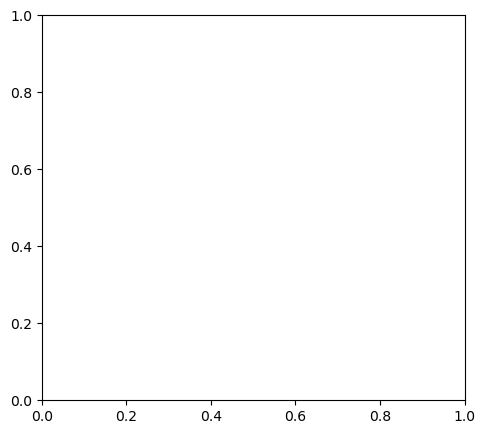

In [9]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_val_losses, label='Val Loss')
plt.title('Best Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label='Train Accuracy')
plt.plot(best_val_accuracies, label='Val Accuracy')
plt.title('Best Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Graph Predictions and Residuals

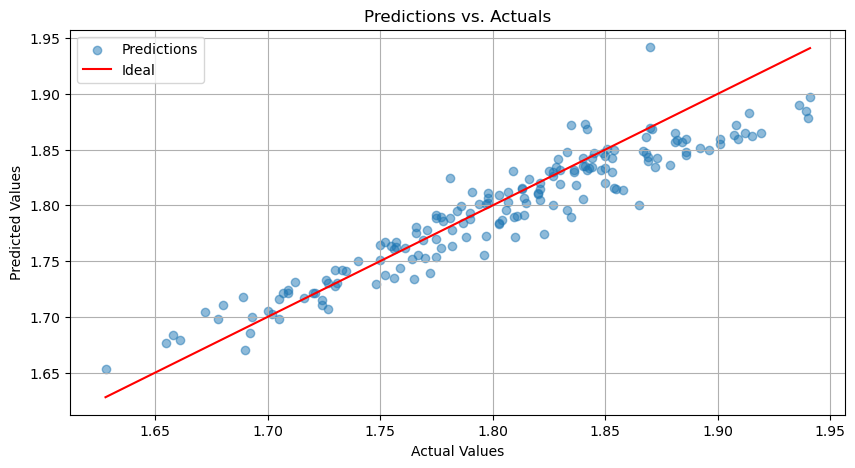

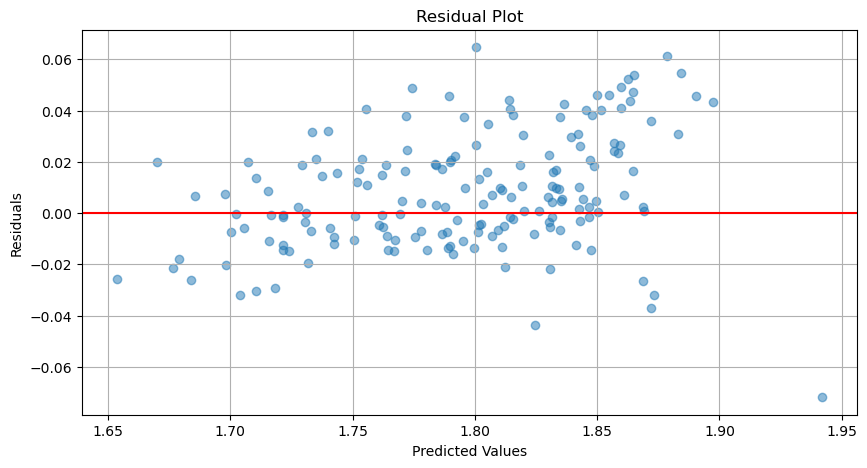

In [ ]:
# Test data
# # Evaluate the best model on the test set
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)# Gather predictions and actual values for plotting

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(labels.view(-1).tolist())

# Plotting Predictions vs. Actual values
plt.figure(figsize=(10, 5))
plt.scatter(actuals, predictions, alpha=0.5, label='Predictions')
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r', label='Ideal')  # Line showing perfect predictions
plt.title('Predictions vs. Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
residuals = [act - pred for act, pred in zip(actuals, predictions)]
plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### Calculate R Squared and Loss on Test Set

In [ ]:
# Calculate R^2 and MSE
test_mse = mean_squared_error(actuals, predictions)
test_r2 = r2_score(actuals, predictions)

print(f"Test MSE: {test_mse}")
print(f"Test R^2: {test_r2}")

Test MSE: 0.0005715870470730931
Test R^2: 0.8673350123298034


### Plot Error Distribution

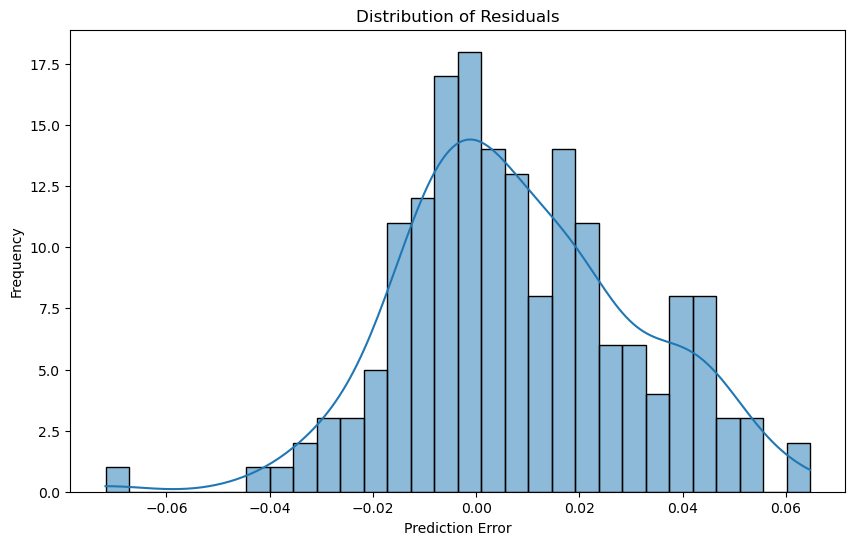

In [ ]:
errors = residuals  # Which are y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()